<a href="https://colab.research.google.com/github/gargjayant/102117156-SESS_LE1/blob/main/102117156_Jayant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: **Jayant Garg**  
Email: `jgarg_be21@thapar.edu`  
Roll No: **102117156**  
Group: **4CS6**  
Start Timestamp: 20240911-1000  

1 Logistics
===========

  + Start time: Wed Sep 11 10:00 AM
  + End Time: Wed Sep 11 04:00 PM
  + Submission Form:
    <https://docs.google.com/forms/d/e/1FAIpQLSc2aAG33E0rQgs3OsrpyjyREwy9OKK_WnKqmBLvD7pzM4sOvg/viewform?usp=sf_link>
  + Viva Voce: Will be notified later.


2 Task
======

  Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.


3 Deliverables
==============

  1. A PDF Report: (as a part of your Git Repo) named
     <ROLL_NO>-report.pdf
  2. Assets: Your pretrained classifier model weights and your cleaned
     and well-formed dataset.  This should be a part of your google
     drive with read access to your instructor <bv.raghav@thapar.edu>
  3. A demo notebook: (as a part of your Git Repo), that loads both your
     model and dataset; and runs to show the results.
  4. The demo notebook should verify the assets using a checksum
     (md5/sha/…).  This step verifies that the assets have not been
     tampered with at a later stage.


4 Evaluation
============

  1. Clarity of thought process and presentation.
  2. Data processing skills.
  3. Model fine tuning/ training skills.
  4. Details of progress, as in what were the encountered problems and
     how were they solved.
  5. How adaptable is your pipeline? (as in, how easy is it for me to
     adapt it for my voice)
  6. How scalable is your approach? (as in, how easy is it to scale it
     to many new voices)
  7. Strengths and Shortcomings of your approach.


5 Note
======

  1. This is a test of how fast can we report the performance of a model
     for a specific task.  The best performance is not expected; but a
     holistic pipeline is.
  2. You may improve upon it in future, out of interest; though it
     wouldn’t influence your eval.

## Solution

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
!pip install torchaudio


In [3]:
import torchaudio
from torch.utils.data import DataLoader


dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root='.',
    download=True
)


data_loader = DataLoader(dataset, batch_size=16, shuffle=True)


100%|██████████| 2.26G/2.26G [00:33<00:00, 73.4MB/s]


In [4]:
!pip install torch torchaudio matplotlib numpy


In [5]:
import torchaudio
from collections import Counter
import matplotlib.pyplot as plt

In [6]:
dataset = torchaudio.datasets.SPEECHCOMMANDS(root='.', download=True)

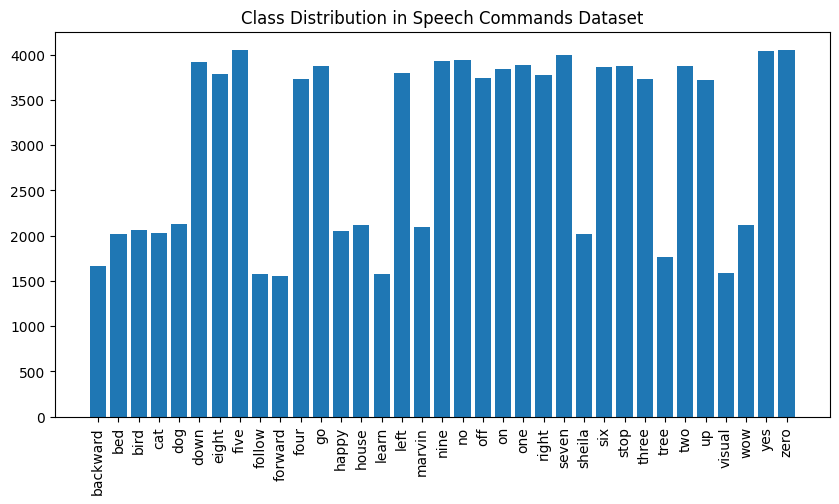

Total number of samples: 105829
Class distribution: Counter({'five': 4052, 'zero': 4052, 'yes': 4044, 'seven': 3998, 'no': 3941, 'nine': 3934, 'down': 3917, 'one': 3890, 'go': 3880, 'two': 3880, 'stop': 3872, 'six': 3860, 'on': 3845, 'left': 3801, 'eight': 3787, 'right': 3778, 'off': 3745, 'four': 3728, 'three': 3727, 'up': 3723, 'dog': 2128, 'wow': 2123, 'house': 2113, 'marvin': 2100, 'bird': 2064, 'happy': 2054, 'cat': 2031, 'sheila': 2022, 'bed': 2014, 'tree': 1759, 'backward': 1664, 'visual': 1592, 'follow': 1579, 'learn': 1575, 'forward': 1557})


In [7]:
def get_labels(dataset):
    return [sample[2] for sample in dataset]


labels = get_labels(dataset)
label_counter = Counter(labels)

plt.figure(figsize=(10, 5))
plt.bar(label_counter.keys(), label_counter.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in Speech Commands Dataset")
plt.show()


total_samples = len(dataset)
print(f"Total number of samples: {total_samples}")
print(f"Class distribution: {label_counter}")

In [15]:
class SpeechCommandsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, label, *_ = self.dataset[idx]
        waveform = pad_audio(waveform)
        waveform = waveform.squeeze(0)
        waveform = waveform.unsqueeze(0)  # Ensure shape is [1, sequence_length] for 1D CNN
        return waveform, label


In [12]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2)


        self.pool = nn.AdaptiveAvgPool1d(32)

        self.fc1 = nn.Linear(32 * 32, 128)
        self.fc2 = nn.Linear(128, len(label_counter))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader
import torch.optim as optim
from collections import Counter


def pad_audio(audio, target_length=16000):
    if audio.shape[1] < target_length:
        padding = target_length - audio.shape[1]
        audio = torch.nn.functional.pad(audio, (0, padding))
    return audio


class SpeechCommandsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, label, *_ = self.dataset[idx]
        waveform = pad_audio(waveform)
        waveform = waveform.squeeze(0)
        waveform = waveform.unsqueeze(0)
        return waveform, label


dataset = torchaudio.datasets.SPEECHCOMMANDS(root='.', download=True)
processed_dataset = SpeechCommandsDataset(dataset)


data_loader = DataLoader(processed_dataset, batch_size=16, shuffle=True)


labels = [sample[1] for sample in dataset]
label_counter = Counter(labels)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2)
        self.pool = nn.AdaptiveAvgPool1d(32)
        self.fc1 = nn.Linear(32 * 32, 128)
        self.fc2 = nn.Linear(128, len(label_counter))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.tensor([label_counter[l] for l in labels]))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(data_loader)}")

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.tensor([label_counter[l] for l in labels])).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")

evaluate_model(model, data_loader)
